In [1]:
import os
import urllib

from torchvision.datasets.utils import download_and_extract_archive
from sklearn.metrics import roc_curve, roc_auc_score

from mico_competition.scoring import tpr_at_fpr, score, generate_roc, generate_table
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np
import torch
import csv
import copy

from torch.autograd import Variable
from sklearn import metrics
from tqdm.notebook import tqdm
from torch.distributions import normal
from torch.utils.data import DataLoader, Dataset
from mico_competition import ChallengeDataset, load_purchase100, load_model
from torch.distributions import Categorical
import torch.nn.utils.prune as prune

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch as ch
import torch.nn as nn

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from scipy.stats import norm

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier
import lightgbm as lgb

In [3]:
from catboost import CatBoostClassifier
from tpot import TPOTClassifier
import autosklearn.classification

In [4]:
def normalize_preds(preds):
    # Normalize to unit interval
    min_prediction = np.min(preds)
    max_prediction = np.max(preds)
    preds = (preds - min_prediction) / (max_prediction - min_prediction)
    return preds

In [5]:
def get_class_scaled_logits(model, features, labels):
    outputs = model(features).detach().cpu().numpy()
    num_classes = np.arange(outputs.shape[1])
    values = []
    for i, output in enumerate(outputs):
        label = labels[i].item()
        wanted = output[label]
        not_wanted = output[np.delete(num_classes, label)]
        values.append(wanted - np.max(not_wanted))
    return np.array(values)

In [6]:
# Collect "training data" using models from train split
def collect_models():
    CHALLENGE = "purchase100"
    LEN_TRAINING = 150000
    LEN_CHALLENGE = 100

    scenarios = os.listdir(CHALLENGE)
    phases = ['dev', 'final', 'train']

    dataset = load_purchase100(dataset_dir="/u/as9rw/work/MICO/data")

    collected_models = {x:[] for x in scenarios}
    phase = "train"
    for scenario in tqdm(scenarios, desc="scenario"):
        root = os.path.join(CHALLENGE, scenario, phase)
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
            challenge_points = challenge_dataset.get_challenges()
            
            model = load_model('purchase100', path)
            collected_models[scenario].append(model)

        collected_models[scenario] = np.array(collected_models[scenario], dtype=object)
            
    return collected_models

In [7]:
train_models = collect_models()

Successfully loaded the Purchase-100 dataset consisting of 197324 records and 600 attributes.


scenario:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
def get_class_scaled_logits(model, features, labels):
    outputs = model(features).detach().cpu().numpy()
    num_classes = np.arange(outputs.shape[1])
    values = []
    for i, output in enumerate(outputs):
        label = labels[i].item()
        wanted = output[label]
        not_wanted = output[np.delete(num_classes, label)]
        values.append(wanted - np.max(not_wanted))
    return np.array(values)

In [11]:
def ascent_recovery(model, features, labels, adv: bool = False):
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    n_times = 10
    step_size = 0.01
    final_losses, final_dist = [], []
    for i, (feature, label) in enumerate(zip(features, labels)):
        model.zero_grad()
        feature_var = Variable(feature.clone().detach(), requires_grad=True)
        for j in range(n_times):
            feature_var = Variable(feature_var.clone().detach(), requires_grad=True)
            loss = criterion(torch.unsqueeze(model(feature_var), 0), torch.unsqueeze(label, 0))
            loss.backward(ch.ones_like(loss), retain_graph=True)
            with ch.no_grad():
                if adv:
                    feature_var.data += step_size * feature_var.data
                else:
                    feature_var.data -= step_size * feature_var.data
                loss_new = criterion(torch.unsqueeze(model(feature_var), 0), torch.unsqueeze(label, 0))
        # Get reduction in loss
        final_losses.append(loss.item() - loss_new.item())
        # Get change in data (norm)
        final_dist.append(ch.norm(feature_var.data - feature.data).detach().cpu().numpy())
    final_losses = np.stack((final_losses, final_dist), 1)
    return final_losses.reshape(-1, 2)

In [9]:
def matt_modified_scores(model, features, labels, model_reference):
    """
        MATT attack from https://arxiv.org/pdf/1908.11229.pdf
        Modified to adapt to the availability of auxiliary models
    """
    criterion = nn.CrossEntropyLoss(reduction='none')
    cos = nn.CosineSimilarity(dim=0)
    features_collected = []

    # Make copy of model
    model_ = copy.deepcopy(model)
    model_.cuda()

    for i, (feature, label) in enumerate(zip(features, labels)):
        # Compute gradients with both models
        model_.zero_grad()
        model_reference.zero_grad()
        loss = criterion(ch.unsqueeze(model_(feature), 0), ch.unsqueeze(label, 0))
        loss_ref = criterion(ch.unsqueeze(model_reference(feature), 0), ch.unsqueeze(label, 0))
        loss.backward()
        loss_ref.backward()
        
        # Compute product
        inner_features = []
        for p1, p2 in zip(model_.parameters(), model_reference.parameters()):
            term = ch.dot(p1.grad.detach().flatten(), p2.grad.detach().flatten()).item()
            inner_features.append(term)
        features_collected.append(inner_features)
    features_collected = np.array(features_collected)
    # Focus only on W0, W1
    features_collected = features_collected[:, [0, 2]]
    return features_collected

In [12]:
def extended_epoch(model, features, labels):
    """
        "Train" model on given data to see how much loss changes.
        If was with DP, not seen many times (and with clipped gradient), so
        expected loss decrease would be much more than that for some point
        that has already been seen multiple times.
        While at it, also take note of gradients
    """
    lr = 0.0005
    criterion = nn.CrossEntropyLoss(reduction='none')
    features_collected = []
    # Note losses currently
    base_preds = model(features).detach()
    base_losses = criterion(base_preds, labels).cpu().numpy()
    for i, (feature, label) in enumerate(zip(features, labels)):
        # Make copy of model
        model_ = copy.deepcopy(model)
        model_.train()
        model_.cuda()
        optimizer = ch.optim.SGD(model_.parameters(), lr=lr, momentum=0)
        optimizer.zero_grad()
        loss = criterion(ch.unsqueeze(model_(feature), 0), ch.unsqueeze(label, 0))
        loss.backward()
        optimizer.step()
        # Keep track of gradient norms
        gradient_norms = [ch.linalg.norm(x.grad.detach().cpu()).item() for x in model_.parameters()]
        # Keep track of updated loss
        loss_new = criterion(ch.unsqueeze(model_(feature), 0), ch.unsqueeze(label, 0)).detach().cpu().numpy()
        loss_difference = (base_losses[i] - loss_new).item()
        gradient_norms += [loss_difference]
        features_collected.append(gradient_norms)
    features_collected = np.array(features_collected)
    features_collected = features_collected.reshape(features_collected.shape[0], -1)
    # Do not care about biases or loss diff
    features_collected = features_collected[:, [0, 2, 4]]
    # features_collected = np.log(features_collected + 1e-10)
    return features_collected.reshape(features_collected.shape[0], -1)

In [13]:
# Attack based on checking robustness in neighborhood
@torch.no_grad()
def relative_log_merlin(model, features, labels):
    epsilon = 0.2
    small_value = 1e-10
    n_neighbors = 50
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    noise = normal.Normal(0, epsilon)
    diffs = []
    base_preds = model(features)
    base_losses = criterion(base_preds, labels).cpu().numpy()
    base_preds = base_preds.cpu().numpy()
    for i, feature in enumerate(features):
        neighbors = []
        distances = []
        for _ in range(n_neighbors):
            sampled_noise = noise.sample(feature.shape).to(feature.device)
            neighbors.append(feature + sampled_noise)
            distances.append(sampled_noise.mean().cpu().item())
        neighbors = torch.stack(neighbors, 0)
        loss_neighbors = criterion(model(neighbors), labels[i].view(1).repeat(n_neighbors))
        loss_change = ch.norm((loss_neighbors - base_losses[i])).item()
        # Use relative drop instead of absolute
        loss_change /= (small_value + base_losses[i].item())
        diffs.append(np.log(loss_change + small_value))
    diffs = np.array(diffs)
    # Clip at zero (lower side)
    diffs[diffs < 0] = 0
    return diffs

In [14]:
def blind_walk(model, features, labels):
    # Track the number of steps taken until decision flips 
    # Walk no more than 100 steps, and try 10 different random directions
    num_directions = 10
    num_max_steps = 100
    point_of_failure = np.ones((num_directions, features.shape[0])) * np.inf
    std = 0.01
    for j in range(num_directions):
        noise = ch.randn_like(features) * std
        for i in range(1, num_max_steps + 1):
            new_labels = ch.argmax(model(features + noise * i).detach(), 1)
            flipped = np.nonzero((new_labels != labels).cpu().numpy())[0]
            point_of_failure[j][flipped] = np.minimum(point_of_failure[j][flipped], i)
    point_of_failure = np.clip(point_of_failure, 0, num_max_steps)
    point_of_failure = np.mean(point_of_failure, 0)
    return point_of_failure.reshape(-1, 1)

In [15]:
def custom_feature_collection(model, features, labels):
    features_collected = []
    features_collected.append(ascent_recovery(model, features, labels))
    features_collected.append(ascent_recovery(model, features, labels, adv = True))
    features_collected.append(extended_epoch(model, features, labels))
    features_collected.append(relative_log_merlin(model, features, labels).reshape(-1, 1))
    features_collected.append(get_class_scaled_logits(model, features, labels).reshape(-1, 1))
    features_collected.append(blind_walk(model, features, labels).reshape(-1, 1))
    combined_feratures = np.concatenate(features_collected, 1)
    return combined_feratures

In [18]:
# Train different meta-classifiers per scenario
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)
phase = "train"
dataset = load_purchase100(dataset_dir="/u/as9rw/work/MICO/data")
LEN_TRAINING = 150000
LEN_CHALLENGE = 100
num_use_others = 50

X_for_meta, Y_for_meta = {}, {}

# Check performance of approach on (1, n-1) models from train
for scenario in tqdm(scenarios, desc="scenario"):
    preds_all = []
    scores_all = []
    root = os.path.join(CHALLENGE, scenario, phase)
    all_except = np.arange(100)

    for i, model_folder in tqdm(enumerate(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1]))), desc="model", total=100):
        path = os.path.join(root, model_folder)
        challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
        challenge_points = challenge_dataset.get_challenges()
        
        challenge_dataloader = torch.utils.data.DataLoader(challenge_points, batch_size=2*LEN_CHALLENGE)
        features, labels = next(iter(challenge_dataloader))
        features, labels = features.cuda(), labels.cuda()
            
        model = load_model('purchase100', path)
        model.cuda()
        features, labels = features.cuda(), labels.cuda()
        # Look at all models except this one
        other_models = train_models[scenario][np.delete(all_except, i)]
        other_models = np.random.choice(other_models, num_use_others, replace=False)
        features_collected = np.array([matt_modified_scores(model, features, labels, other_model.cuda()) for other_model in other_models])
        scores = np.stack((
            np.max(features_collected[:, :, 0], 0) - np.min(features_collected[:, :,  0], 0),
            np.max(features_collected[:, :,  1], 0) - np.min(features_collected[:, :,  1], 0),
            np.sum(np.abs(features_collected[:, :,  0]), 0),
            np.sum(np.abs(features_collected[:, :,  1]), 0),
            np.min(features_collected[:, :,  0], 0),
            np.min(features_collected[:, :,  1], 0),
            np.max(features_collected[:, :,  0], 0),
            np.max(features_collected[:, :,  1], 0),
        ), 1)
        mem_labels = challenge_dataset.get_solutions()
        
        # Also get scaled logit scores while at it
        other_features = custom_feature_collection(model, features, labels)
        scores = np.concatenate((scores, other_features), 1)

        # Store
        preds_all.append(mem_labels)
        scores_all.append(scores)
    
    preds_all = np.concatenate(preds_all)
    scores_all = np.concatenate(scores_all)
    
    X_for_meta[scenario] = scores_all
    Y_for_meta[scenario] = preds_all

Successfully loaded the Purchase-100 dataset consisting of 197324 records and 600 attributes.


scenario:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)

bins = 50
for sc in scenarios:
    index = 8
    use = np.copy(X_for_meta[sc][:, index])
    eps = 1e-10
    model_to_look = 1
    membership_info = Y_for_meta[sc][200 * model_to_look:200 * (model_to_look + 1)]
    #plt.hist(use[membership_info == 0], bins, alpha=0.3, label='non-members')
    #plt.hist(use[membership_info == 1], bins, alpha=0.3, label='members')
    plt.hist(use[Y_for_meta[sc] == 0], bins, alpha=0.3, label='non-members')
    plt.hist(use[Y_for_meta[sc] == 1], bins, alpha=0.3, label='members')
    plt.legend(loc='upper right')
    plt.rcParams['figure.dpi'] = 100
    plt.show()
    break

In [ ]:
# Visualize scores to identify scope for improvement via combination
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)

for sc in scenarios:
    wanted_zero, wanted_one = X_for_meta[sc][Y_for_meta[sc] == 0], X_for_meta[sc][Y_for_meta[sc] == 1]
    index = 4
    other = 5
    plt.scatter(wanted_zero[:, index], wanted_zero[:, other], label='non-members', s=2, alpha=0.5)
    plt.scatter(wanted_one[:, index], wanted_one[:, other], label='members', s=2, alpha=0.5)
    plt.legend(loc='upper right')
    plt.show()
    break

In [ ]:
# Train different meta-classifiers per scenario
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)

# depths = [4, 5, 6, 7, 8]
# depths = [5, 10, 25, 50, 100]
depths = [50, 100, 150, 200]
seeds = [18, 28, 38, 48, 58, 68, 78, 88, 98]

for depth in depths:
    inner_scores = [0, 0, 0]
    for seed in seeds:
        # meta_clf = RandomForestClassifier(max_depth=depth, n_estimators=200, max_samples=0.8)
        meta_clf = MLPClassifier(hidden_layer_sizes=(16, 8, 4), max_iter=depth)
        #meta_clf = CatBoostClassifier(iterations=depth, verbose=0)
        X_tr, X_te, Y_tr, Y_te = [], [], [], []
        for i, sc in enumerate(scenarios):
            # Split at data level
            # X_train, X_test, y_train, y_test = train_test_split(X_for_meta[sc], Y_for_meta[sc], test_size=0.1, random_state=seed)
            # Split at model level
            train_split_og, test_split_og = train_test_split(np.arange(100), test_size=10, random_state=seed)
            train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
            test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
            X_train = X_for_meta[sc][train_split]
            X_test = X_for_meta[sc][test_split]
            y_train = Y_for_meta[sc][train_split]
            y_test = Y_for_meta[sc][test_split]
            
            extra_features = np.array(other_other_features[sc]["train"])
            extra_train = extra_features[train_split_og]
            extra_test = extra_features[test_split_og]
            extra_train = extra_train.reshape(len(X_train), -1)
            extra_test  = extra_test.reshape(len(X_test), -1)
            X_train = np.concatenate((X_train, extra_train), 1)
            X_test = np.concatenate((X_test, extra_test), 1)

            # Train common model only for low and high DP
            if i != 0:
                X_tr.append(np.concatenate((np.ones((len(X_train), 1)) * i, X_train), axis=1))
                Y_tr.append(y_train)
            X_te.append(np.concatenate((np.ones((len(X_test), 1)) * i, X_test), axis=1))
            Y_te.append(y_test)
    
        X_tr = np.concatenate(X_tr, 0)
        Y_tr = np.concatenate(Y_tr, 0)

        meta_clf.fit(X_tr, Y_tr)
        preds_inf = meta_clf.predict_proba(X_te[0])[:, 1]
        preds_hi = meta_clf.predict_proba(X_te[1])[:, 1]
        preds_lo = meta_clf.predict_proba(X_te[2])[:, 1]
        scores_inf = score(Y_te[0], preds_inf)
        scores_hi = score(Y_te[1], preds_hi)
        scores_lo = score(Y_te[2], preds_lo)
        scores_inf.pop('fpr', None)
        scores_inf.pop('tpr', None)
        scores_hi.pop('fpr', None)
        scores_hi.pop('tpr', None)
        scores_lo.pop('fpr', None)
        scores_lo.pop('tpr', None)
        #display(pd.DataFrame([scores]))
        inner_scores[0] += scores_inf['TPR_FPR_1000']
        inner_scores[1] += scores_hi['TPR_FPR_1000']
        inner_scores[2] += scores_lo['TPR_FPR_1000']
    combined = sum(inner_scores) / (3 * len(seeds))
    print("Depth: %d | Scores: combined:%.4f | inf:%.4f, hi:%.4f, lo:%.4f" % (depth, combined, inner_scores[0] / len(seeds), inner_scores[1] / len(seeds), inner_scores[2] / len(seeds)))

In [19]:
import autosklearn.metrics

In [ ]:
from tpot.config.classifier import classifier_config_dict

new_config = classifier_config_dict.copy()
del new_config['sklearn.svm.LinearSVC']

In [69]:
# Train one meta-classifier overall
CHALLENGE = "purchase100"
# meta_clf = RandomForestClassifier(max_depth=7, n_estimators=200, max_samples=0.8)
# meta_clf = CatBoostClassifier()
# meta_clf = MLPClassifier(hidden_layer_sizes=(16, 8, 4), max_iter=100, verbose=True)
meta_clf = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    metric=autosklearn.metrics.roc_auc)
# meta_clf = TPOTClassifier(config_dict=new_config,
#                           scoring='roc_auc', verbosity=3,
#                           n_jobs=18,
#                           generations=5,
#                           population_size=20,
#                           max_time_mins=5)

X_tr, X_te, Y_tr, Y_te = [], [], [], []
use_all = True
for i, sc in enumerate(scenarios):
    # Split at model level
    train_split_og, test_split_og = train_test_split(np.arange(100), test_size=20)
    train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
    test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
    if use_all:
        X_train = X_for_meta[sc]
        X_test  = X_for_meta[sc]
        y_train = Y_for_meta[sc]
        y_test  = Y_for_meta[sc]
    else:
        X_train = X_for_meta[sc][train_split]
        X_test = X_for_meta[sc][test_split]
        y_train = Y_for_meta[sc][train_split]
        y_test = Y_for_meta[sc][test_split]

    # Skip non-DP
    X_tr.append(np.concatenate((np.ones((len(X_train), 1)) * i, X_train), axis=1))
    Y_tr.append(y_train)

    X_te.append(np.concatenate((np.ones((len(X_test), 1)) * i, X_test), axis=1))    
    Y_te.append(y_test)
    
X_tr = np.concatenate(X_tr, 0)
Y_tr = np.concatenate(Y_tr, 0)
meta_clf.fit(X_tr, Y_tr)

for i, sc in enumerate(scenarios):
    preds = meta_clf.predict_proba(X_te[i])[:, 1]
    scores = score(Y_te[i], preds)
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))

[WARNING] [2023-01-24 08:58:43,201:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 08:59:14,635:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-24 08:59:46,061:Client-EnsembleBuilder] No runs were available to build an ensemble from


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0224,0.1176,0.2735,0.3888,0.4967,0.5862,0.779851,0.4183,0.70915


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0075,0.0551,0.171,0.2499,0.3286,0.4057,0.664258,0.2385,0.61925


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0111,0.0606,0.1683,0.2503,0.3341,0.4011,0.655679,0.2269,0.61345


In [ ]:
# Train one meta-classifier overall
CHALLENGE = "purchase100"
meta_clf = CatBoostClassifier(iterations=1000, learning_rate=0.02, verbose=0)

X_tr, X_te, Y_tr, Y_te = [], [], [], []
use_all = True
for i, sc in enumerate(scenarios):
    # Split at model level
    train_split_og, test_split_og = train_test_split(np.arange(100), test_size=25)
    train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
    test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
    extra_features = np.array(other_other_features[sc]["train"])
    if use_all:
        X_train = X_for_meta[sc]
        X_test  = X_for_meta[sc]
        y_train = Y_for_meta[sc]
        y_test  = Y_for_meta[sc]
        extra_train = extra_features
        extra_test = extra_features
    else:
        X_train = X_for_meta[sc][train_split]
        X_test = X_for_meta[sc][test_split]
        y_train = Y_for_meta[sc][train_split]
        y_test = Y_for_meta[sc][test_split]
        extra_train = extra_features[train_split_og]
        extra_test = extra_features[test_split_og]
    
    extra_train = extra_train.reshape(len(X_train), -1)
    extra_test  = extra_test.reshape(len(X_test), -1)
    
    X_train = np.concatenate((X_train, extra_train), 1)
    X_test = np.concatenate((X_test, extra_test), 1)

    # Skip non-DP
    X_tr.append(np.concatenate((np.ones((len(X_train), 1)) * i, X_train), axis=1))
    Y_tr.append(y_train)

    X_te.append(np.concatenate((np.ones((len(X_test), 1)) * i, X_test), axis=1))    
    Y_te.append(y_test)
    
X_tr = np.concatenate(X_tr, 0)
Y_tr = np.concatenate(Y_tr, 0)

X_te_all = np.concatenate(X_te, 0)
Y_te_all = np.concatenate(Y_te, 0)

if use_all:
    meta_clf.fit(X_tr, Y_tr)
else:
    meta_clf.fit(X_tr, Y_tr, eval_set=(X_te_all, Y_te_all))

for i, sc in enumerate(scenarios):
    preds = meta_clf.predict_proba(X_te[i])[:, 1]
    scores = score(Y_te[i], preds)
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))

In [ ]:
# Train different meta-classifiers per scenario
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)

depths = [2, 3, 4]
# depths = [5, 10, 25, 50, 100]
seeds = [8, 18, 28, 38, 48, 58, 68, 78, 88, 98] #, 108, 118, 128]

for depth in depths:
    inner_scores = [0, 0, 0]
    for seed in seeds:
        meta_clfs = {x: CatBoostClassifier(max_depth=depth, iterations=1000, verbose=0) for x in X_for_meta.keys()}
        # meta_clfs = {x: RandomForestClassifier(max_depth=depth, n_estimators=200, max_samples=0.8) for x in X_for_meta.keys()}
        X_tr, X_te, Y_tr, Y_te = [], [], [], []
        preds_sc, yte_sc = [], []
        for i, sc in enumerate(scenarios):
            # Split at model level
            train_split_og, test_split_og = train_test_split(np.arange(100), test_size=20, random_state=seed)
            train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
            test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
            X_train = X_for_meta[sc][train_split]
            X_test = X_for_meta[sc][test_split]
            y_train = Y_for_meta[sc][train_split]
            y_test = Y_for_meta[sc][test_split]
            
            extra_features = np.array(other_other_features[sc]["train"])
            extra_train = extra_features[train_split_og]
            extra_test = extra_features[test_split_og]
            extra_train = extra_train.reshape(len(X_train), -1)
            extra_test  = extra_test.reshape(len(X_test), -1)
            X_train = np.concatenate((X_train, extra_train), 1)
            X_test = np.concatenate((X_test, extra_test), 1)
            
            meta_clfs[sc].fit(X_train, y_train)
            preds = meta_clfs[sc].predict_proba(X_test)[:, 1]
            preds_sc.append(preds)
            yte_sc.append(y_test)

        scores_hi = score(yte_sc[0], preds_sc[0])
        scores_inf = score(yte_sc[0], preds_sc[0])
        scores_hi = score(yte_sc[1], preds_sc[1])
        scores_lo = score(yte_sc[2], preds_sc[2])
        scores_inf.pop('fpr', None)
        scores_inf.pop('tpr', None)
        scores_hi.pop('fpr', None)
        scores_hi.pop('tpr', None)
        scores_lo.pop('fpr', None)
        scores_lo.pop('tpr', None)
#         display(pd.DataFrame([scores]))
        inner_scores[0] += scores_inf['TPR_FPR_1000']
        inner_scores[1] += scores_hi['TPR_FPR_1000']
        inner_scores[2] += scores_lo['TPR_FPR_1000']
    print("Depth: %d | Scores: inf:%.4f, hi:%.4f, lo:%.4f" % (depth, inner_scores[0] / len(seeds), inner_scores[1] / len(seeds), inner_scores[2] / len(seeds)))

In [101]:
# Train different meta-classifiers per scenario
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)
# depths_ = [8, 8, 8]
# depths_ = [8, 8, 5] # Works best so far
# meta_clfs = {x: RandomForestClassifier(max_depth=depths_[ii], n_estimators=200, max_samples=0.8) for ii, x in enumerate(X_for_meta.keys())}
# meta_clfs = {x: TPOTClassifier(config_dict=new_config, scoring='roc_auc', verbosity=3, n_jobs=18, generations=5, population_size=20, max_time_mins=10) for ii, x in enumerate(X_for_meta.keys())}
# meta_clfs = {x: TPOTClassifier(config_dict=new_config, scoring='roc_auc', verbosity=2, n_jobs=16, generations=8, population_size=30) for ii, x in enumerate(X_for_meta.keys())}
# max_time_mins=1, max_eval_time_mins=1, generations=5, population_size=5

# Best so far:
# meta_clfs = {x: autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=180, metric=autosklearn.metrics.roc_auc) for ii, x in enumerate(X_for_meta.keys())}
meta_clfs = {x: autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=900, resampling_strategy='cv', metric=autosklearn.metrics.roc_auc) for ii, x in enumerate(X_for_meta.keys())}

avg = 0
use_all = True
for sc in scenarios:
    train_split_og, test_split_og = train_test_split(np.arange(100), test_size=20)
    train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
    test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
    if use_all:
        X_train = X_for_meta[sc]
        X_test  = X_for_meta[sc]
        y_train = Y_for_meta[sc]
        y_test  = Y_for_meta[sc]
    else:
        
        X_train = X_for_meta[sc][train_split]
        X_test  = X_for_meta[sc][test_split]
        y_train = Y_for_meta[sc][train_split]
        y_test  = Y_for_meta[sc][test_split]

    meta_clfs[sc].fit(X_train, y_train)
    preds = meta_clfs[sc].predict_proba(X_test)[:, 1]
    preds_train = meta_clfs[sc].predict_proba(X_train)[:, 1]
    
    print(f"{sc} AUC (train): {roc_auc_score(y_train, preds_train)}")
    scores = score(y_test, preds)
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))
    avg += scores['TPR_FPR_1000']

print("Average score", avg / 3)

[WARNING] [2023-01-26 10:00:29,958:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-26 10:02:01,422:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-26 10:03:32,842:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-01-26 10:03:35,307:Client-EnsembleBuilder] No runs were available to build an ensemble from
purchase100_inf AUC (train): 0.67121382


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.015,0.059,0.1552,0.2454,0.3146,0.381,0.671214,0.2189,0.60945


[WARNING] [2023-01-26 10:15:30,887:Client-EnsembleBuilder] No runs were available to build an ensemble from
purchase100_hi AUC (train): 0.55645119


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0023,0.0181,0.0702,0.1362,0.1976,0.2563,0.556451,0.0829,0.54145


[WARNING] [2023-01-26 10:30:26,560:Client-EnsembleBuilder] No runs were available to build an ensemble from
purchase100_lo AUC (train): 0.55531862


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0022,0.0204,0.0757,0.1428,0.1992,0.2591,0.555319,0.0799,0.53995


Average score 0.17479999999999998


In [ ]:
# Train different meta-classifiers per scenario
CHALLENGE = "purchase100"
scenarios = os.listdir(CHALLENGE)
# meta_clfs = {x: CatBoostClassifier(iterations=1000, learning_rate=0.01) for ii, x in enumerate(X_for_meta.keys())}
meta_clfs = {x: CatBoostClassifier(verbose=0) for ii, x in enumerate(X_for_meta.keys())}

avg = 0
for sc in scenarios:
    train_split_og, test_split_og = train_test_split(np.arange(100), test_size=30)
    train_split = np.concatenate([np.arange(200) + 200 * i for i in train_split_og])
    test_split = np.concatenate([np.arange(200) + 200 * i for i in test_split_og])
    extra_features = np.array(other_other_features[sc]["train"])
        
    X_train = X_for_meta[sc][train_split]
    X_test  = X_for_meta[sc][test_split]
    y_train = Y_for_meta[sc][train_split]
    y_test  = Y_for_meta[sc][test_split]
    extra_train = extra_features[train_split_og]
    extra_test = extra_features[test_split_og]
    
    extra_train = extra_train.reshape(len(X_train), -1)
    extra_test  = extra_test.reshape(len(X_test), -1)
    
    X_train = np.concatenate((X_train, extra_train), 1)
    X_test = np.concatenate((X_test, extra_test), 1)

    meta_clfs[sc].fit(X_train, y_train, eval_set=(X_test, y_test))
    preds = meta_clfs[sc].predict_proba(X_test)[:, 1]
    preds_train = meta_clfs[sc].predict_proba(X_train)[:, 1]
    
    print(f"{sc} AUC (train): {roc_auc_score(y_train, preds_train)}")
    scores = score(y_test, preds)
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))
    avg += scores['TPR_FPR_1000']

print("Average score", avg / 3)

## Collect features

In [ ]:
CHALLENGE = "purchase100"
LEN_TRAINING = 150000
LEN_CHALLENGE = 100

scenarios = os.listdir(CHALLENGE)
phases = ['dev', 'final', 'train']
stored_features = {}

dataset = load_purchase100(dataset_dir="/u/as9rw/work/MICO/data")

for i, scenario in tqdm(enumerate(scenarios), desc="scenario", total=3):
    stored_features[scenario] = {}
    for phase in tqdm(phases, desc="phase"):
        stored_features[scenario][phase] = []
        root = os.path.join(CHALLENGE, scenario, phase)
        all_except = np.arange(100)
        for j, model_folder in tqdm(enumerate(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1]))), desc="model", total=len(os.listdir(root))):
            path = os.path.join(root, model_folder)
            challenge_dataset = ChallengeDataset.from_path(path, dataset=dataset, len_training=LEN_TRAINING)
            challenge_points = challenge_dataset.get_challenges()
            
            model = load_model('purchase100', path)
            challenge_dataloader = torch.utils.data.DataLoader(challenge_points, batch_size=2*LEN_CHALLENGE)
            features, labels = next(iter(challenge_dataloader))

            model.cuda()
            features, labels = features.cuda(), labels.cuda()
            # Look at all models except this one
            other_models = train_models[scenario][np.delete(all_except, j)]
            other_models = np.random.choice(other_models, num_use_others, replace=False)
            features_collected = np.array([matt_modified_scores(model, features, labels, other_model.cuda()) for other_model in other_models])
            scores = np.stack((
                np.max(features_collected[:, :, 0], 0) - np.min(features_collected[:, :,  0], 0),
                np.max(features_collected[:, :,  1], 0) - np.min(features_collected[:, :,  1], 0),
                np.sum(np.abs(features_collected[:, :,  0]), 0),
                np.sum(np.abs(features_collected[:, :,  1]), 0),
                np.min(features_collected[:, :,  0], 0),
                np.min(features_collected[:, :,  1], 0),
                np.max(features_collected[:, :,  0], 0),
                np.max(features_collected[:, :,  1], 0),
            ), 1)
            # Also get scaled logit scores while at it
            other_features = custom_feature_collection(model, features, labels)
            processed_features = np.concatenate((scores, other_features), 1)
            # MATT-inspired + custom features
            stored_features[scenario][phase].append(processed_features)

Successfully loaded the Purchase-100 dataset consisting of 197324 records and 600 attributes.


scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

## Generate predictions

In [102]:
CHALLENGE = "purchase100"
LEN_TRAINING = 150000
LEN_CHALLENGE = 100

scenarios = os.listdir(CHALLENGE)
phases = ['dev', 'final', 'train']

dataset = load_purchase100(dataset_dir="/u/as9rw/work/MICO/data")

for i, scenario in tqdm(enumerate(scenarios), desc="scenario", total=3):
    for phase in tqdm(phases, desc="phase"):
        root = os.path.join(CHALLENGE, scenario, phase)
        j = 0
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            features_use = stored_features[scenario][phase][j]
            
            # Using common meta-classifier
#             features_use = np.concatenate((np.ones((len(features_use), 1)) * i, features_use), axis=1)
#             predictions = meta_clf.predict_proba(features_use)[:, 1]
            # Using scenario-wise meta-classifier
            predictions = meta_clfs[scenario].predict_proba(features_use)[:, 1]
            j += 1
            assert np.all((0 <= predictions) & (predictions <= 1))

            with open(os.path.join(path, "prediction.csv"), "w") as f:
                 csv.writer(f).writerow(predictions)

Successfully loaded the Purchase-100 dataset consisting of 197324 records and 600 attributes.


scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/3 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

## Scoring

Let's see how the attack does on `train`, for which we have the ground truth. 
When preparing a submission, you can use part of `train` to develop an attack and a held-out part to evaluate your attack. 

In [103]:
FPR_THRESHOLD = 0.1

all_scores = {}
phases = ['train']

for scenario in tqdm(scenarios, desc="scenario"): 
    all_scores[scenario] = {}    
    for phase in tqdm(phases, desc="phase"):
        predictions = []
        solutions  = []

        root = os.path.join(CHALLENGE, scenario, phase)
        for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
            path = os.path.join(root, model_folder)
            predictions.append(np.loadtxt(os.path.join(path, "prediction.csv"), delimiter=","))
            solutions.append(np.loadtxt(os.path.join(path, "solution.csv"),   delimiter=","))

        predictions = np.concatenate(predictions)
        solutions = np.concatenate(solutions)
        
        scores = score(solutions, predictions)
        all_scores[scenario][phase] = scores

scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/1 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/1 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

phase:   0%|          | 0/1 [00:00<?, ?it/s]

model:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot the ROC curve for the attack and see how the attack performed on different metrics

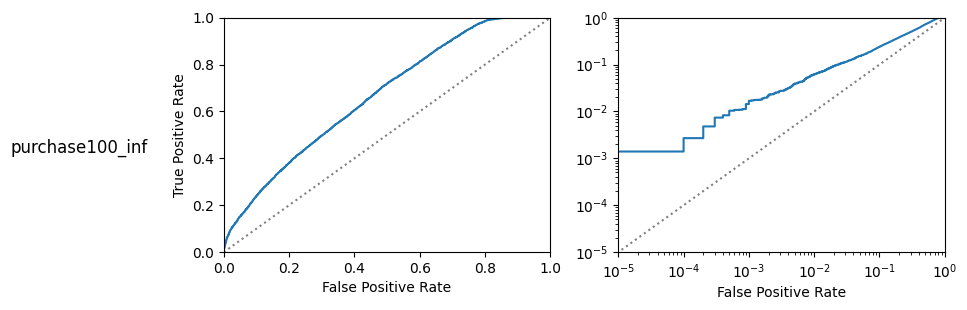

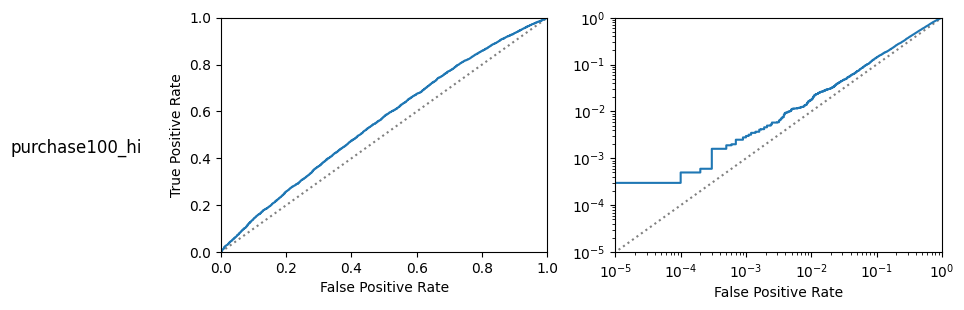

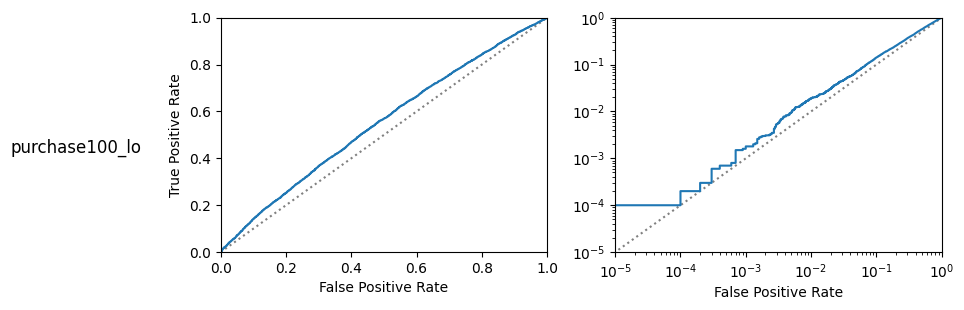

In [104]:
import matplotlib.pyplot as plt
import matplotlib

for scenario in scenarios:
    fpr = all_scores[scenario]['train']['fpr']
    tpr = all_scores[scenario]['train']['tpr']
    fig = generate_roc(fpr, tpr)
    fig.suptitle(f"{scenario}", x=-0.1, y=0.5)
    fig.tight_layout(pad=1.0)

In [105]:
import pandas as pd

for scenario in scenarios:
    print(scenario)
    scores = all_scores[scenario]['train']
    scores.pop('fpr', None)
    scores.pop('tpr', None)
    display(pd.DataFrame([scores]))

purchase100_inf


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0144,0.0616,0.1525,0.2388,0.3131,0.38,0.668182,0.2201,0.61005


purchase100_hi


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0028,0.0174,0.0717,0.1414,0.1961,0.2576,0.556173,0.0798,0.5399


purchase100_lo


,TPR_FPR_10,TPR_FPR_100,TPR_FPR_500,TPR_FPR_1000,TPR_FPR_1500,TPR_FPR_2000,AUC,MIA,accuracy
0,0.0016,0.0188,0.0711,0.1418,0.199,0.2526,0.549566,0.0734,0.5367


## Packaging the submission

Now we can store the predictions into a zip file, which you can submit to CodaLab.

In [106]:
import zipfile

phases = ['dev', 'final']
experiment_name = "autosklearn_15m_cv"

with zipfile.ZipFile(f"submissions/{experiment_name}.zip", 'w') as zipf:
    for scenario in tqdm(scenarios, desc="scenario"): 
        for phase in tqdm(phases, desc="phase"):
            root = os.path.join(CHALLENGE, scenario, phase)
            for model_folder in tqdm(sorted(os.listdir(root), key=lambda d: int(d.split('_')[1])), desc="model"):
                path = os.path.join(root, model_folder)
                file = os.path.join(path, "prediction.csv")
                if os.path.exists(file):
                    zipf.write(file)
                else:
                    raise FileNotFoundError(f"`prediction.csv` not found in {path}. You need to provide predictions for all challenges")

scenario:   0%|          | 0/3 [00:00<?, ?it/s]

phase:   0%|          | 0/2 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

phase:   0%|          | 0/2 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

phase:   0%|          | 0/2 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]

model:   0%|          | 0/50 [00:00<?, ?it/s]